In [12]:
%pip install -q petals bibtexparser pybtex colorama tabulate==0.9.0 pylcs rouge-score

  Preparing metadata (setup.py) ... done


In [13]:
import os
import math
import heapq
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pylcs
warnings.filterwarnings('ignore')

from typing import Callable
from transformers import BloomTokenizerFast, DebertaForSequenceClassification, DebertaTokenizer
from petals import DistributedBloomForCausalLM
from dataclasses import dataclass
from tqdm.notebook import trange
from tabulate import tabulate, SEPARATING_LINE
from colorama import Fore
from rouge_score import rouge_scorer

In [3]:
# load model

MODEL_NAME = "bigscience/bloomz-petals"
tokenizer = BloomTokenizerFast.from_pretrained(MODEL_NAME)
model = DistributedBloomForCausalLM.from_pretrained(MODEL_NAME)
model = model.cuda()

Downloading:   0%|          | 0.00/319 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/637 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/7.19G [00:00<?, ?B/s]

In [4]:
# load ACL dataset

if not os.path.exists('anthology+abstracts.bib'):
    !wget https://aclanthology.org/anthology+abstracts.bib.gz
    !gzip -d anthology+abstracts.bib.gz

def parse_field(s):
    parts = s.split('"')
    assert len(parts) == 3 and parts[-1] == ','
    return parts[1]

entries = []
abstract, title = None, None
with open('anthology+abstracts.bib') as f:
    for line in f.readlines():
        parsed_line = line.strip()
        if parsed_line.startswith('abstract = "'):
            abstract = parse_field(parsed_line)
        elif parsed_line.startswith('title = "'):
            title = parse_field(parsed_line)
        elif parsed_line == '}' and abstract is not None and title is not None:
            entries.append({'abstract': abstract, 'title': title})
            abstract, title = None, None

entries[0]

--2023-03-19 19:17:01--  https://aclanthology.org/anthology+abstracts.bib.gz
Resolving aclanthology.org (aclanthology.org)... 174.138.37.75
Connecting to aclanthology.org (aclanthology.org)|174.138.37.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19684896 (19M) [application/x-gzip]
Saving to: ‘anthology+abstracts.bib.gz’

anthology+abstracts 100%[===================>]  18.77M  6.68MB/s    in 2.8s    

2023-03-19 19:17:05 (6.68 MB/s) - ‘anthology+abstracts.bib.gz’ saved [19684896/19684896]



{'abstract': 'In this paper, we discuss the challenges that we faced during the construction of a Universal Dependencies treebank for Abaza, a polysynthetic Northwest Caucasian language. We propose an alternative to the morpheme-level annotation of polysynthetic languages introduced in Park et al. (2021). Our approach aims at reducing the number of morphological features, yet providing all the necessary information for the comprehensive representation of all the syntactic relations. Besides, we suggest to add one language-specific relation needed for annotating repetitions in spoken texts and present several solutions that aim at increasing cross-linguistic comparability of our data.',
 'title': 'Building a {U}niversal {D}ependencies Treebank for a Polysynthetic Language: the Case of {A}baza'}

## Uncertanty estimation using CPMI

Will use the following formula (from the [CPMI paper](https://arxiv.org/pdf/2210.13210.pdf)) for greedy text generation:

$\text{score}(y | y_{<t}, x) = \log p(y | y_{<t}, x) - \lambda \cdot \mathbb{1} \left\{H(p(. | y_{<t}, x)) \ge \tau\right\} \cdot \log p(y | y_{<t})$

Experimented with following hyperparameters:

* $\lambda = 0, \tau = 0$: without marginal term

* $\lambda = 0.0656, \tau = 3.599$: best hyperparameters from paper (for BARTS2S)

Used 2 different estimates of uncertalty for each token:

* $\arg\max\limits_{y_t} \text{score}(y_t | y_{<t}, x)$

* $H \left(\text{score}(. | y_{<t}, x)\right)$

In [5]:
# from transformers.generation_logits_process import LogitsProcessor

# class MyCustomLogitsProcessor(LogitsProcessor):
#     def __init__(self):
#         pass

#     def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor):
#         return scores

# inputs = tokenizer('Hello', return_tensors="pt")["input_ids"].cuda()
# outputs = model.generate(inputs, max_new_tokens=10, logits_processor=MyCustomLogitsProcessor())

In [6]:
# Greedy inference implementation (model.generate doesn't work with custom LogitsProcessor :()

def calculate_logits(session, model, new_token):
    embs = model.transformer.word_embeddings(new_token)
    embs = model.transformer.word_embeddings_layernorm(embs)
    h = session.step(embs)
    h_last = model.transformer.ln_f(h[:, -1])
    logits = model.lm_head(h_last).reshape(-1)
    return F.log_softmax(logits, dim=-1)
  
def calculate_entropy(logits):
    normalized_logits = F.log_softmax(logits, dim=-1)
    return -(normalized_logits * normalized_logits.exp()).sum()

def greedy_inference(
    model, tokenizer,
    input: torch.LongTensor, max_new_tokens: int,
    lambd: float, tau: float,
    verbose: bool = False,
):
    max_tokens = input.shape[-1] + max_new_tokens
    assert input.shape[0] == 1, 'Batch_size should be 1'
    with torch.inference_mode():
        with model.inference_session(max_length=max_tokens) as sess_conditional:  # for calculating p(y_t | x, y_1...y_t-1) 
            with model.inference_session(max_length=max_tokens) as sess_marginal:  # for calculating p(y_t | y_1...y_t-1)
                conditional_tokens = input
                marginal_tokens = torch.LongTensor([[tokenizer.bos_token_id]]).cuda()
                tokens_list, scores_list, entropies_list = [], [], []

                for iter in trange(max_new_tokens, leave=False):
                    conditional_logits = calculate_logits(
                        sess_conditional, model, conditional_tokens)  # p(y_t | x, y_1...y_t-1)
                    if lambd > 0:
                        marginal_logits = calculate_logits(
                            sess_marginal, model, marginal_tokens)  # p(y_t | y_1...y_t-1)
                    
                    # calculate score from logits (CPMI formula)
                    score = conditional_logits
                    if lambd > 0 and calculate_entropy(conditional_logits) >= tau:
                        score -= lambd * marginal_logits

                    new_token = score.argmax()
                    tokens_list.append(new_token)
                    scores_list.append(score.max().item())
                    entropies_list.append(calculate_entropy(score).item())

                    conditional_tokens = new_token.reshape(1, 1)
                    marginal_tokens = new_token.reshape(1, 1)

                    if verbose:
                        print('Iteration {}:\t{}'.format(iter, tokenizer.decode(tokens_list)))
                    
                    if new_token == tokenizer.eos_token_id:
                        break
    
    return tokens_list, np.array(scores_list), np.array(entropies_list)

In [7]:
# experiment utils

def gen_text_query(entry):
    return 'Generate abstract for article with title "{}".'.format(entry['title'])

def apply_colors(decoded_tokens, scores_list, score_bounds, colors):
    colored = []
    for score, token in zip(scores_list, decoded_tokens):
        if score_bounds is not None and colors is not None:
            for b, c in zip(score_bounds, colors):
                if b >= score:
                    token = c + token + Fore.RESET
                    break
        colored.append(token)
    return colored

def print_tokens_with_uncertanties(
    tokenizer, tokens_list, scores_list, entropies_list,
    score_bounds=None, entropy_bounds=None, colors=None,
):
    decoded_tokens = [tokenizer.decode([t]) for t in tokens_list]
    print(tabulate([
        [''] + apply_colors(decoded_tokens, scores_list, score_bounds, colors),
        ['max(score)'] + ['%s' % float('%.3g' % score) for score in scores_list],
        SEPARATING_LINE,
        [''] + apply_colors(decoded_tokens, -entropies_list, -entropy_bounds, colors),
        ['H(scores)'] + ['%s' % float('%.3g' % ent) for ent in entropies_list]
    ]))

def mark_bins(patches, bins, score_bounds, colors):
    for i in range(len(patches)):
        for b, c in zip(score_bounds, colors):
            if bins[i] <= b:
                patches[i].set_facecolor(c)
                break

def experiment(model, tokenizer, text_query, lambd, tau, max_new_tokens=100):
    print('=' * 100)
    print('Lambda = {}, Tau = {}'.format(lambd, tau))

    inputs = tokenizer(text_query, return_tensors="pt")["input_ids"].cuda()
    output_tokens, output_scores, output_entropies = greedy_inference(
        model, tokenizer, inputs, max_new_tokens, lambd, tau)

    print(' Query:', text_query)
    print('Answer:', tokenizer.decode(output_tokens))
    print()

    Q1_score, Q2_score = -2.0, -1.5
    Q1_ent, Q2_ent = 4.0, 5.5
    print_tokens_with_uncertanties(
        tokenizer, output_tokens, output_scores, output_entropies,
        score_bounds=np.array([Q1_score, Q2_score, math.inf]),
        entropy_bounds=np.array([Q2_ent, Q1_ent, -math.inf]),
        colors=[Fore.RED, Fore.YELLOW, Fore.GREEN])

    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    _, bins, patches = ax1.hist(output_scores)
    ax1.set_xlabel('$score(y_t | y_{<t}, x)$')
    ax1.set_title('Scores histogram')
    mark_bins(patches, bins, [Q1_score, Q2_score, math.inf], ['r', 'y', 'g'])
    _, bins, patches = ax2.hist(output_entropies)
    ax2.set_xlabel('$H(. | y_{<t}, x)$')
    ax2.set_title('Entropies histogram')
    mark_bins(patches, [-b for b in bins], [-Q2_ent, -Q1_ent, math.inf], ['r', 'y', 'g'])
    
    plt.show()

    return output_tokens, output_scores

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

 Query: Generate abstract for article with title "Automatic Orality Identification in Historical Texts".
Answer:  The goal of this research is to develop a system that can automatically identify the orality of historical texts.</s>

----------  -----  -----  -------  -----  ---------  ------  -----  --------  -----  -------  ------  -----  --------------  ---------  -----  -----  -------  ------  -----------  ------  ------  ----
             The    goal   of       this   research   is      to     develop   a      system   that    can    automatically   identify   the    or    ality     of      historical   texts  .       </s>
max(score)  -1.88  -3.33  -0.0552  -1.08  -1.12      -0.432  -0.15  -1.16     -1.18  -1.73    -0.891  -1.12  -0.648          -0.5       -1.66  -2.53  -0.0337  -0.641  -1.02        -0.355  -0.625  -1.6
----------  -----  -----  -------  -----  ---------  ------  -----  --------  -----  -------  ------  -----  --------------  ---------  -----  -----  -------  -----

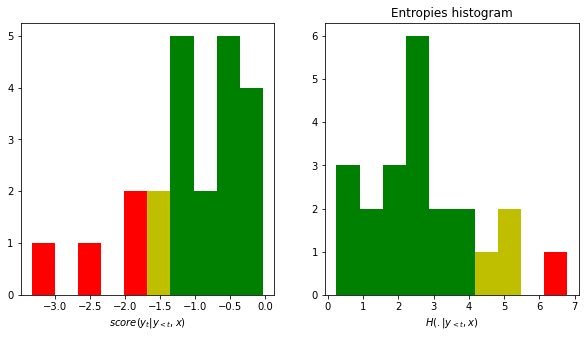

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

 Query: Generate abstract for article with title "Automatic Orality Identification in Historical Texts".
Answer:  The automatic detection of oral language in historical texts is a challenging task. The main difficulty is the lack of training data. In this paper, we present a novel approach to this problem. We use a large amount of data from the present day to train a classifier that can identify oral language in historical texts. We show that our approach is able to identify oral language in historical texts with a high accuracy.</s>

----------  ----  ----------  ----------  ------  -----  ---------  ------  -----------  ------  ------  -----  ------------  ------  -----  -----  -----  -----------  -----  ----  -----  --------  ---------  -----  -----  -----  ------  ------  ------  ------  --------  ------  ------  ---------  -----  -----  --------  -----  ------  -----  -----  ------  -------  --------  -----  ------  -----  --------  ----  ------  ------  ------  -----------  -----

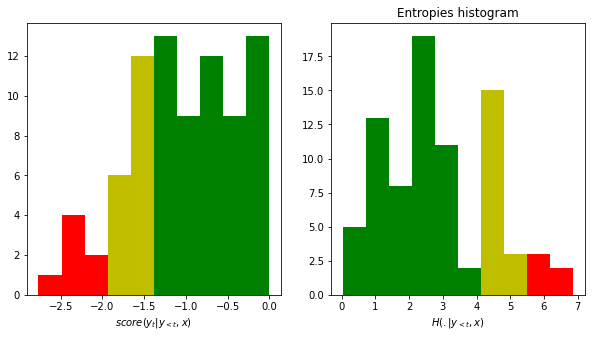

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

 Query: Generate abstract for article with title "Toward Self-Learning End-to-End Task-oriented Dialog Systems".
Answer: </s>

----------  -----
            </s>
max(score)  -2.22
----------  -----
            </s>
H(scores)   4.41
----------  -----


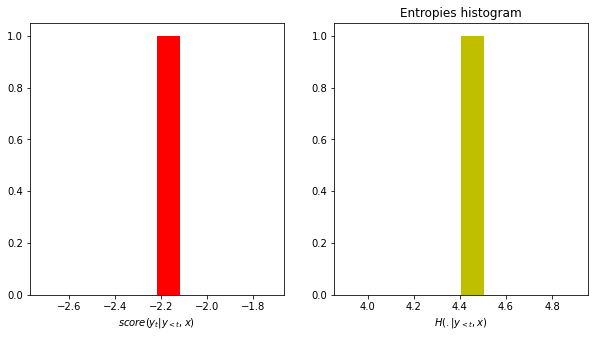

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

 Query: Generate abstract for article with title "Toward Self-Learning End-to-End Task-oriented Dialog Systems".
Answer:  End-to-End Task-oriented Dialog Systems (EETDS) are a new generation of conversational agents that are able to learn from scratch how to perform a task. In this paper, we present a novel approach to EETDS that is based on a deep reinforcement learning (DRL) algorithm. The proposed approach is able to learn from scratch how to perform a task by interacting with a human. The proposed approach is evaluated on a real-world task, namely, booking a flight. The results

----------  -----  -----  --------  -----  ---------  -------  --------  -----  ------  ----  ------  ------  ------  -----  -----  -----------  -------  --------  ---------  -------  ------  -----  -----  --------  ------  -----  --------  -----  --------  --------  -----  -----  -----  -----  ------  ------  ------  ------  --------  -----  ------  ---------  ------  -----  --------  ---------  -----  ---

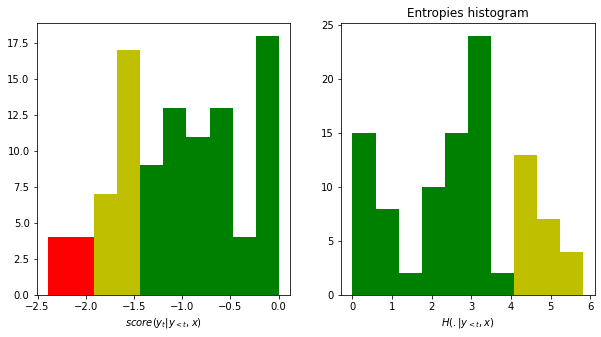

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

 Query: Generate abstract for article with title "Extraction automatique de motifs syntaxiques".
Answer:  La recherche de motifs syntaxiques est une technique de traitement automatique du langage naturel qui consiste à rechercher des motifs récurrents dans un corpus de textes.</s>

----------  -----  ----------  -----  -------  -------  -------  -----  ------  ----------  -----  -----------  ------------  ------  --------  --------  -----  ---------  -------  -----------  ------  -------  -----  ---------  --------  ------  -----  -------  ------  -------  ------  -----
             La     recherche   de     motifs   syntax  iques     est    une     technique   de     traitement   automatique   du      langage   naturel   qui    consiste   à        rechercher   des     motifs   réc   urr        ents       dans    un     corpus   de      textes  .       </s>
max(score)  -2.62  -2.28       -1.11  -0.137   -0.254   -0.0129  -1.16  -0.871  -1.93       -1.73  -1.12        -0.424        -0.8

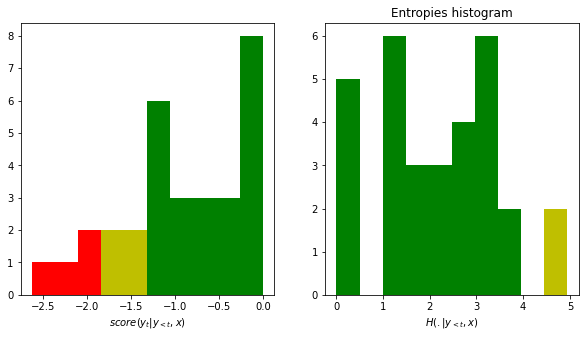

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

 Query: Generate abstract for article with title "Extraction automatique de motifs syntaxiques".
Answer:  La recherche de motifs syntaxiques est une technique de traitement automatique du langage naturel qui consiste à rechercher des motifs récurrents dans un corpus de textes.</s>

----------  -----  ----------  -----  -------  -------  -------  -----  ------  ----------  -----  -----------  ------------  ------  --------  --------  -----  ---------  -------  -----------  ------  -------  -----  ---------  --------  ------  -----  -------  ------  -------  ------  -----
             La     recherche   de     motifs   syntax  iques     est    une     technique   de     traitement   automatique   du      langage   naturel   qui    consiste   à        rechercher   des     motifs   réc   urr        ents       dans    un     corpus   de      textes  .       </s>
max(score)  -1.99  -1.85       -1.16  -0.136   -0.262   -0.0131  -1.25  -0.828  -1.93       -1.59  -1.12        -0.414        -0.8

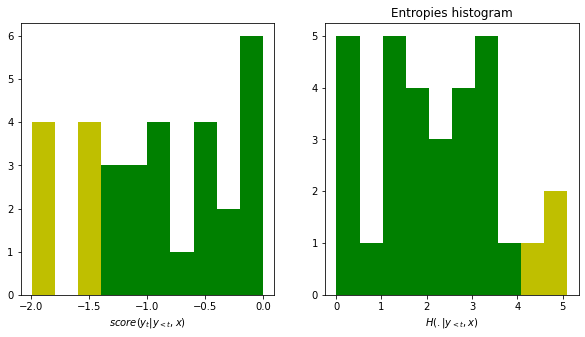

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

 Query: Generate abstract for article with title "{S}tory{DB}: Broad Multi-language Narrative Dataset".
Answer:  StoryDB, LLC. Retrieved March 5, 2021. StoryDB is a company that provides a platform for the creation, management, and distribution of narrative data.</s>

----------  ------  -----  -----  ----  ------  ----------  ------  -----  --------  -------  -----  ------  ------  ------  ------  --------  ------  ---------  -----  ---------  ------  -----  ---------  ------  -----------  ------  ------  -------------  --------  ----------  -----  ------  -----
             Story  DB     ,       LLC  .        Retrieved   March   5     ,         2021     .       Story  DB       is      a       company   that    provides   a      platform   for     the    creation  ,        management  ,        and     distribution   of        narrative   data  .       </s>
max(score)  -1.9    -1.57  -1.39  -1.3  -0.805  -2.23       -2.7    -3.11  -0.00123    -1.86  -0.19  -0.699  -0.063  -0.664  -0.22

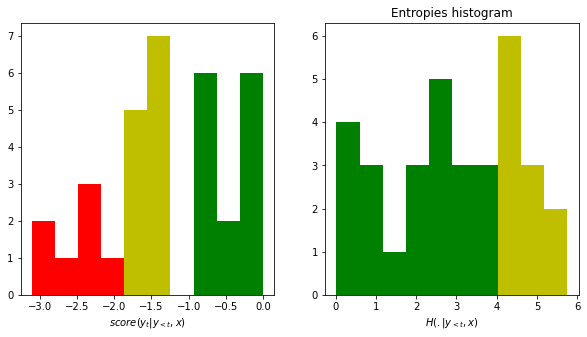

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

 Query: Generate abstract for article with title "{S}tory{DB}: Broad Multi-language Narrative Dataset".
Answer:  StoryDB, LLC. Retrieved March 5, 2021. StoryDB is a multi-language narrative dataset that includes over 1,000,000 stories from over 100,000 authors.</s>

----------  ------  ------  -----  ------  ------  ----------  ------  -----  --------  -------  ------  ------  ------  ------  ------  ------  ---------  ----------  --------  -----  ---------  -----  -----  -----  ------  ------  --------  --------  -----  -----  ------  -----  --------  --------  ------  -----
             Story  DB      ,       LLC    .        Retrieved   March   5     ,         2021     .        Story  DB       is      a       multi  -language   narrative   dataset   that   includes   over   1     ,       0      ,        0         stories   from   over  100     ,       0         authors  .       </s>
max(score)  -0.875  -0.672  -1.45  -0.984  -0.766  -1.56       -2.58   -3.09  -0.00132    -1.84  -0.18

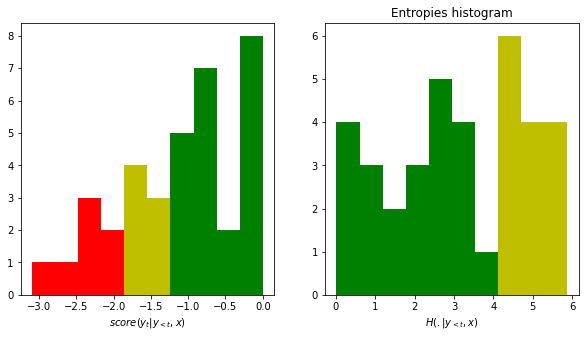

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

 Query: Generate abstract for article with title "{A}i{M}: Taking Answers in Mind to Correct {C}hinese Cloze Tests in Educational Applications".
Answer:  In this paper, we present a novel approach to correcting Chinese Cloze tests in educational applications. The approach is based on the idea of taking answers in mind (AiM), which is a new concept in the field of intelligent tutoring systems. The AiM approach is a combination of a statistical method and a rule-based method. The statistical method is used to identify the most probable answer for each question in a Cloze test. The rule-based method is used to correct the answers that are not

----------  -----  -----  ------  ------  ------  --------  ------  ------  ---------  ------  --------  -----  --------  ------  ---------  ------  ------  ------------  -------------  ------  -----  ---------  -----  ------  -------  -----  -----  -----  -------  --------  ------  -------  -----  ----  -----  ------  ------  -----  ------  -----  

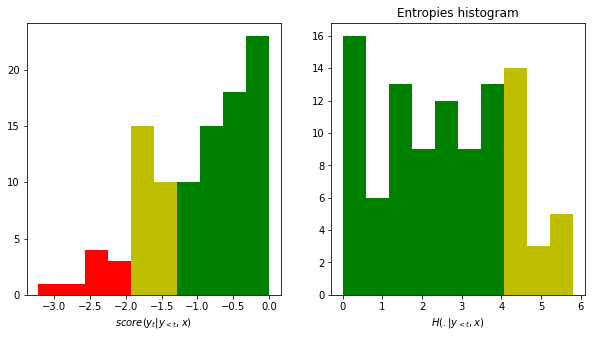

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

 Query: Generate abstract for article with title "{A}i{M}: Taking Answers in Mind to Correct {C}hinese Cloze Tests in Educational Applications".
Answer:  Ai, Ming and Chen, Yi-Hsuan. {M}ind, Brain and Education, vol. {M}, no. {N}, pp. {M}-{M}, {M}-{M}, {M}-{M}, {M}-{M}, {M}-{M}, {M}-{M}, {M}-{M}, {M}-{M}, {M}-{M}, {M}-{M}, {M}-{M}, {M}

----------  -----  -----  -----  -----  -----  -------  ----  ----  -----  ----  ------  -----  -----  ------  ------  -----  ------  ------  ----------  -----  ----  ------  -----  -----  -----  ------  ------  -----  -----  ------  ------  -------  ------  -----  -----  --------  ------  ------  -----  ------  -----  --------  ------  ------  -----  ------  ------  --------  -----  -----  -----  -------  -------  --------  ------  ------  ------  -------  -------  --------  -------  -----  ------  -------  -------  --------  -------  ------  ------  -------  -------  -------  -------  ------  ------  -------  -------  --------  -------  ------  ------

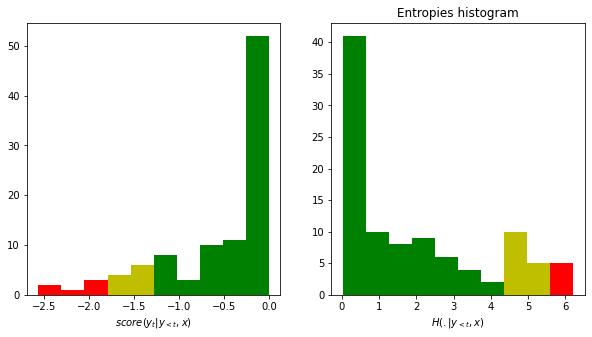

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

 Query: Generate abstract for article with title "{CLARIN}: Distributed Language Resources and Technology in a {E}uropean Infrastructure".
Answer:  The CLARIN project is a European research infrastructure for the development, management and dissemination of language resources and technology. It is funded by the European Commission under the 7th Framework Programme.</s>

----------  ----  ------  ---------  ---------  --------  -----  ------  ---------  ---------  ---------------  -----  -----  ------------  -----  -----------  ------  --------------  --------  ---------  ----------  ------  -----------  ------  -----  ------  -------  -----  -------  ---------  -----------  ------  ------  ----  ----------  ----------  -----  -----
             The   CL     AR         IN          project   is     a       European   research   infrastructure   for    the    development  ,       management   and     dissemination   of        language   resources   and     technology  .        It     is  

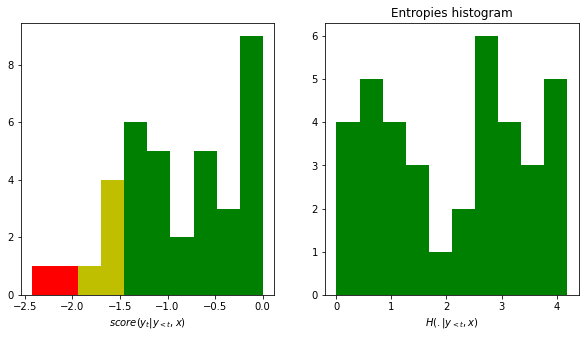

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

 Query: Generate abstract for article with title "{CLARIN}: Distributed Language Resources and Technology in a {E}uropean Infrastructure".
Answer:  The CLARIN project is a European research infrastructure for the development, management and dissemination of language resources and technology. It is funded by the European Commission under the 7th Framework Programme.</s>

----------  ------  ------  ---------  ---------  --------  -----  ------  ---------  ---------  ---------------  -----  ------  ------------  ----  -----------  ------  --------------  --------  ---------  ----------  ------  -----------  ------  -----  ------  -------  ------  -------  ---------  -----------  ------  ------  -----  ----------  ----------  -----  -----
             The     CL     AR         IN          project   is     a       European   research   infrastructure   for    the     development  ,      management   and     dissemination   of        language   resources   and     technology  .        It   

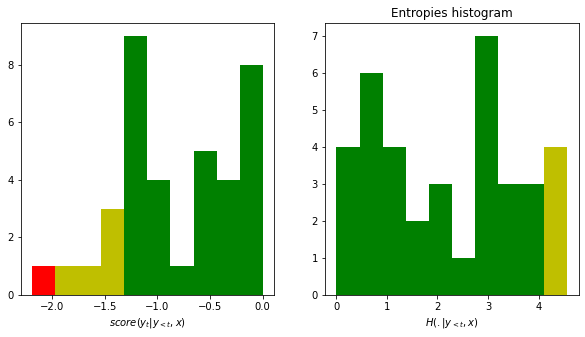

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

 Query: Generate abstract for article with title "{M}orphdb.hu: {H}ungarian lexical database and morphological grammar".
Answer:  Morphdb.hu is a Hungarian lexical database and morphological grammar. It is a part of the Hungarian Language Technology Center (HLT) at the Institute of Informatics of the Hungarian Academy of Sciences.</s>

----------  ------  -------  ------  ------  --------  -----  ------  ----------  ----  --------  ---------  ------  --------------  --------  ------  ------  ------  ----  -----  --------  ------  ----------  ---------  -----------  -------  -----  -----  ------  -----  -----  ------  ----------  ------  -------  ---------  ----  -------  ----------  --------  --------  ---------  ------  -----
             Mor    ph       db      .       hu         is     a       Hungarian   lex  ical       database   and     morphological   grammar  .        It      is      a     part   of        the     Hungarian   Language   Technology   Center   (     H      LT    

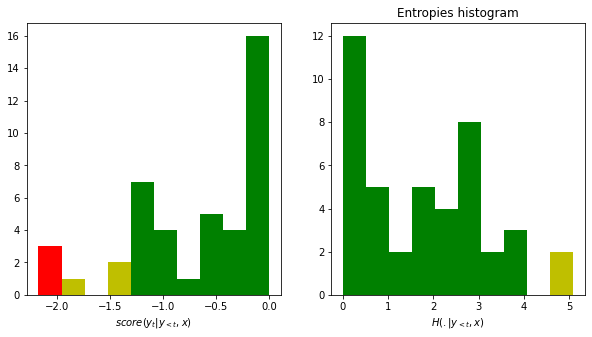

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

 Query: Generate abstract for article with title "{M}orphdb.hu: {H}ungarian lexical database and morphological grammar".
Answer:  Morphdb.hu is a Hungarian lexical database and morphological grammar. It is a part of the Hungarian Language Technology Center (Magyar Köztársaság Teknológia Központ, MKT) at the University of Szeged.</s>

----------  ------  -------  -------  ------  --------  ------  -----  ----------  -----  --------  ---------  ------  --------------  --------  ------  -----  ------  ----  -----  --------  ------  ----------  ---------  -----------  -------  -----  -----  --------  -----  ------  -------  ---------  ------  -----  ------  ------  -----  -------  --------  -----  ------  ------  ------  -----  -----  -----------  -------  ------  ---------  ---------  ------  -----
             Mor    ph       db       .       hu         is      a      Hungarian   lex   ical       database   and     morphological   grammar  .        It     is      a     part   of        t

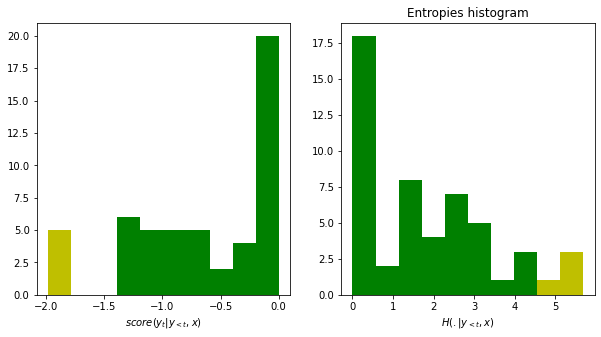

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

 Query: Generate abstract for article with title "{CA}i{RE}{\_}{HKUST} at {S}em{E}val-2019 Task 3: Hierarchical Attention for Dialogue Emotion Classification".
Answer:  The third task of SemEval-2019 is to classify the emotion of a dialogue. The task is divided into two subtasks:</s>

----------  -----  ------  ------  ------  -------  -------  --------  ------  -----  ---------  ------  --------  ------  ------  ---------  -----  -----  -----  -----  --------  -------  ------  ------  ------  ----  -----
             The    third   task    of      Sem     Eval     -2019      is      to     classify   the     emotion   of      a       dialogue  .       The    task   is     divided   into     two     sub    tasks   :     </s>
max(score)  -1.96  -2.19   -0.559  -0.422  -0.0476  -0.0688     -0.35  -0.949  -1.22  -1.09      -0.656  -0.711    -0.535  -0.793  -1.16      -1.27  -1.34  -1.63  -1.45  -1.55     -0.0591  -0.922  -0.336  -0.379  -0.4  -1.73
----------  -----  ------  ------  -----

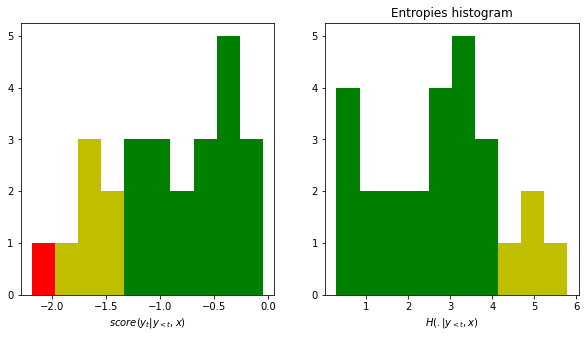

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

 Query: Generate abstract for article with title "{CA}i{RE}{\_}{HKUST} at {S}em{E}val-2019 Task 3: Hierarchical Attention for Dialogue Emotion Classification".
Answer:  The third task of SemEval-2019 is to classify the emotion of a dialogue. The task is divided into two subtasks:</s>

----------  -----  ------  ------  -----  -------  -------  ---------  -----  -----  ---------  ------  --------  ------  ------  ---------  -----  -----  -----  -----  --------  -------  ------  ------  ------  ------  -----
             The    third   task    of     Sem     Eval     -2019       is     to     classify   the     emotion   of      a       dialogue  .       The    task   is     divided   into     two     sub    tasks   :       </s>
max(score)  -1.41  -1.81   -0.527  -0.41  -0.0491  -0.0488     -0.342  -1.05  -1.12  -1.1       -0.664  -0.727    -0.566  -0.742  -1.09      -1.28  -1.24  -1.59  -1.39  -1.54     -0.0574  -0.926  -0.342  -0.379  -0.404  -1.62
----------  -----  ------  ------  --

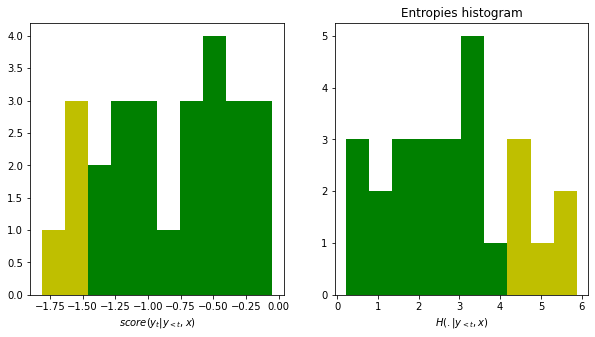

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

 Query: Generate abstract for article with title "Methodological Aspects of Developing and Managing an Etymological Lexical Resource: Introducing {E}tym{DB}-2.0".
Answer:  Etymological dictionaries are dictionaries that record the history of words. They are useful for linguists, historians, and other scholars. The second version of Etymological Database ({E}tym{DB}-2.0) is a new online etymological dictionary of Russian language. It is a continuation of the first version of Etymological Database ({E}tym{DB}-1.0) that was developed in the framework of the Russian Science Foundation project (No. 14-50-00150). The second

----------  -----  --------  -------------  -----  -------------  ------  -------  ------  --------  ------  ------  -----  -----  -----  -------  ------  ------  -------  -----  --------  ---------  ------  -----  ------  ---------  -----  ----  -------  --------  -------  ------  --------  ---------  ------  ------  -------  -------  -------  --------  --------  ------

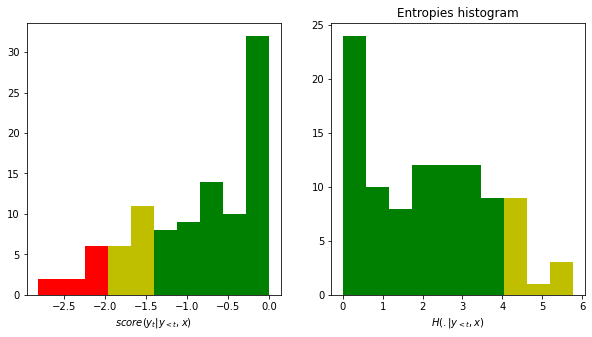

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

 Query: Generate abstract for article with title "Methodological Aspects of Developing and Managing an Etymological Lexical Resource: Introducing {E}tym{DB}-2.0".
Answer:  Etymological dictionaries are dictionaries that record the history of words. They are useful for linguists, historians, and other scholars. The second version of Etymological Database ({E}tym{DB}-2.0) is a new online etymological dictionary of Russian. It is a continuation of the first version of Etymological Database ({E}tym{DB}-1.0) that was developed at the Institute of Russian Language of the Russian Academy of Sciences.</s>

----------  ------  --------  -------------  -----  -------------  ------  -------  ------  --------  ------  ------  ----  -----  -----  -------  ------  ------  -------  ------  --------  ---------  ------  -----  ------  ---------  ----  -----  -------  --------  -------  ------  --------  ---------  ------  ------  -------  -------  -------  --------  --------  -------  --------  -------

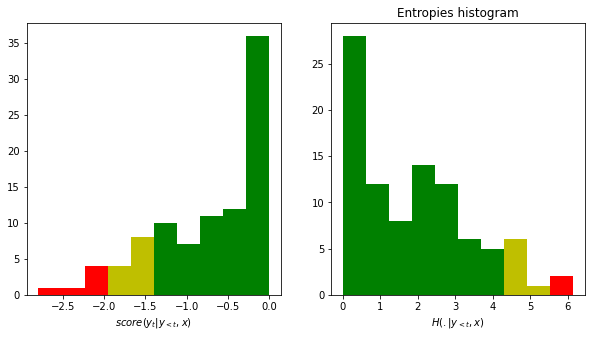

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

 Query: Generate abstract for article with title "Modeling Exemplification in Long-form Question Answering via Retrieval".
Answer:  In this paper, we present a novel approach to long-form question answering (QA) that combines retrieval and modeling exemplification. The approach is based on the observation that the answer to a long-form question is often a set of examples that illustrate the answer. We propose a method for retrieving a set of relevant examples from a large corpus of documents, and then use a model to select the most relevant examples from the retrieved set. The model is trained on a set of examples that are relevant to the question

----------  -----  -----  ------  ------  ------  --------  ------  ------  ---------  ------  -----  ------  ---------  ----------  -----  -----  -----  ------  ---------  ----------  -----  ---------  -------  ---------  ------  -----  ---------  -----  ------  ------  ------  ------------  --------  -----  -------  ------  -----  ------  

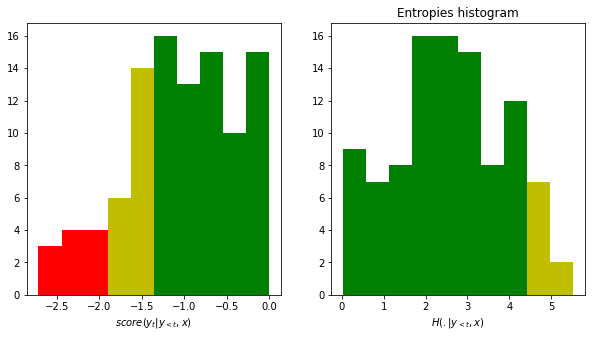

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

 Query: Generate abstract for article with title "Modeling Exemplification in Long-form Question Answering via Retrieval".
Answer:  In this paper, we present a novel approach to long-form question answering (QA) that combines retrieval and modeling. The approach is based on the observation that the answer to a long-form question is often a model of a concept or a situation. We propose a method for extracting the model from the question and then using it to retrieve relevant documents. We show that this approach outperforms a state-of-the-art retrieval-based QA system on a benchmark dataset.</s>

----------  -----  -----  ------  ------  ------  --------  ------  ------  ---------  ------  -----  ------  ---------  ----------  -----  ------  -----  ------  ---------  ----------  -----  ---------  -----  -----  ---------  -----  ------  -------  ------  ------------  --------  -----  -------  -----  ------  ------  -------  ---------  ----  ------  -----  ------  ----  -----  --------  -

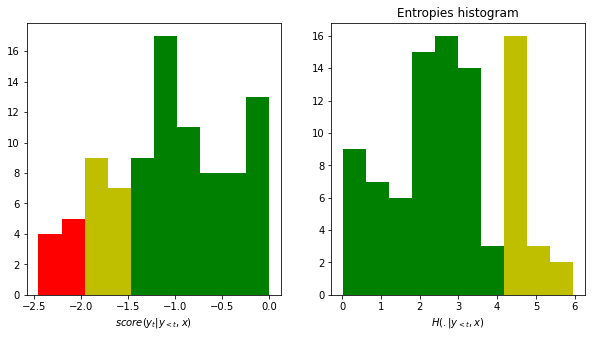

In [ ]:
np.random.seed(42)
for i in np.random.choice(np.arange(len(entries)), 10):
    entry = entries[i]
    text_query = gen_text_query(entry)
    for lambd, tau in [
        (0, 0), # usual greedy inference, without marginal term
        (0.0656, 3.599),  # optimal parameters for BARTS2S as in the paper
    ]:
        output_tokens, output_scores = experiment(model, tokenizer, text_query, lambd, tau)

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

 Query: Write a biography of Albert Enstein.
Answer:  Albert Einstein (/ˈaɪnstaɪn/; German: [ˈalbɐt ˈaɪnʃtaɪn] (listen); March 14, 1879 – April 18, 1955) was a German-born theoretical physicist who developed the general theory of relativity, one of the two pillars of modern physics (the other being quantum mechanics).</s>

----------  -------  ---------  ------  -----  -----  -------  -------  ------  -------  ---------  -----  --------  ------  -------  ------  -------  -------  ------  ------  ------  --------  -------  --------  ------  ------  ------  -------  ------  ------  ---------  -----------  ------  ---------  ---------  ---------  ---------  ------  -------  ------  -------  ------  ------------  -------  ---------  ------  ----------  ---------  --------  -------  ---------  ---------  ---------  ------  ------  ---------  --------  ---------  --------  ---------  -------  --------  --------  ------  ---------  --------  --------  ----------  -------  -----
             A

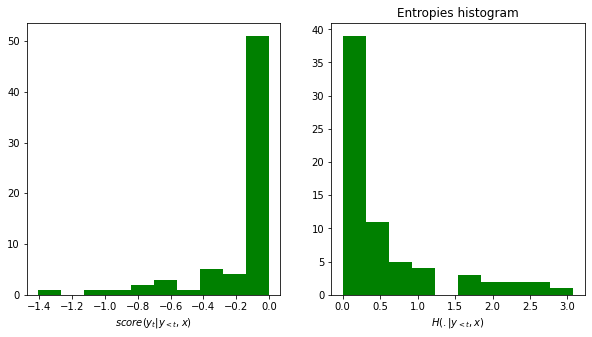

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

 Query: Write a biography of Albert Enstein.
Answer:  Albert Einstein (/ˈaɪnstaɪn/; German: [ˈalbɐt ˈaɪnʃtaɪn] (listen); March 14, 1879 – April 18, 1955) was a German-born theoretical physicist who developed the general theory of relativity, one of the two pillars of modern physics (the other being quantum mechanics). Einstein's work is also known for its influence on the philosophy of space and time.</s>

----------  -------  ---------  ------  -----  ------  -------  -------  ------  -------  ---------  -----  --------  ------  -------  ------  ------  ------  ------  -------  ------  --------  -------  --------  ------  ------  ------  -------  ------  ------  ---------  -----------  ------  ---------  --------  ---------  ---------  -------  -------  -------  -------  ------  ------------  -------  ---------  ------  ----------  ---------  --------  -------  ---------  ---------  ---------  --------  ------  ---------  --------  ---------  --------  ---------  -------  --------  --

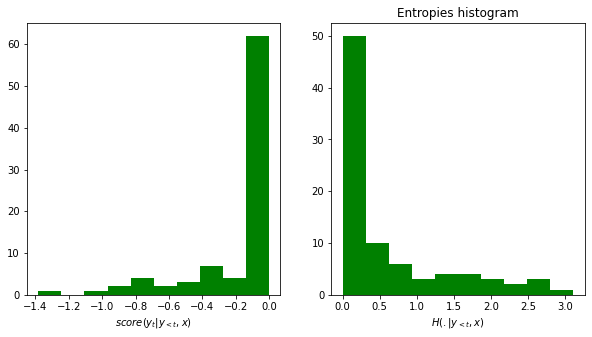

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

 Query: Write a biography of Donald Trump.
Answer:  Donald John Trump (born June 14, 1946) is an American businessman, author, television personality, and politician who served as the 45th president of the United States from January 20, 2017, to January 20, 2021. A Republican, he was the 2016 nominee of his party for president and defeated Democratic nominee Hillary Clinton in the general election.</s>

----------  -------  ------  -------  ------  ------  ------  ------  --------  ----------  -------  -------  ------  ---------  ------------  ------  -------  -------  -----------  ------------  ------  -----  -----------  ------  -------  --------  -------  -------  ---------  ----------  ---------  ---------  ---------  ---------  ------  --------  --------  ---------  ---------  ------  ------  --------  --------  ---------  ----------  -------  -----  -----------  ------  ------  -----  ------  -------  ------  ---------  ------  ------  ------  ------  ----------  ------  --------

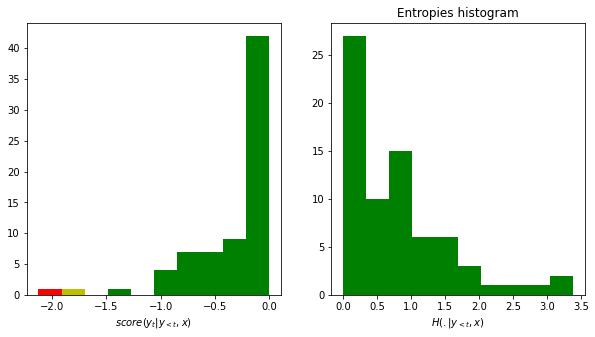

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

 Query: Write a biography of Donald Trump.
Answer:  Donald John Trump (born June 14, 1946) is an American businessman, author, television personality, and politician who served as the 45th president of the United States from January 20, 2017, to January 20, 2021. A Republican, he was the 2016 nominee of his party for president and defeated Democratic nominee Hillary Clinton in the general election.</s>

----------  -------  ------  -------  ------  ------  ------  ------  --------  ----------  -------  -------  ------  ---------  ------------  ------  -------  -------  -----------  ------------  ------  ------  -----------  ------  -------  --------  -------  -------  ---------  ----------  --------  ---------  ---------  ---------  ------  --------  --------  ---------  ---------  ------  ------  --------  --------  ---------  ----------  -------  -----  -----------  ------  ------  -----  ------  -------  ------  ---------  ------  -----  ------  ------  ----------  ------  ---------

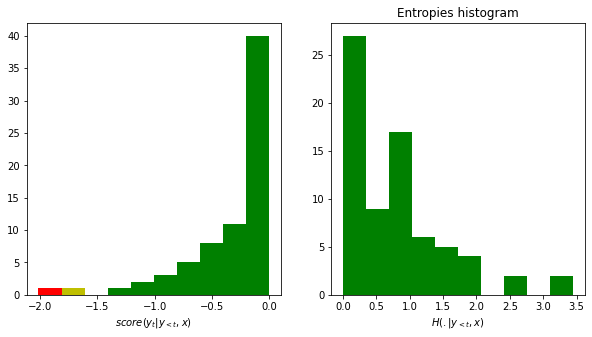

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

 Query: Write a biography of Ekaterina Fadeeva.
Answer:  Ekaterina Fadeeva (Russian: Екатерина Фадеева; born September 16, 1990) is a Russian professional ice dancer. She is the 2014 Olympic silver medalist with partner Sergei Grinkov.</s>

----------  -------  ---------  ------  --------  -------  ------  -----  ---------  ------  -------  --------  --------  ---------  ------  ------  --------  -------  ---------  ------  -------  ----------  -----  -------  -------  ------  -------  -------  --------  -------------  ------  -------  ---------  ------  ------  ------  -----  -------  --------  -------  ------  --------  ------  --------  -------  ---------  -------  ---------  ------  ------
             Ek      aterina     F      ade       eva       (      Russ   ian:        Е      ка       те        ри        на          Ф      а       де        е        ва         ;        born     September  16     ,        1990     )        is       a        Russian   professional   ice     dan 

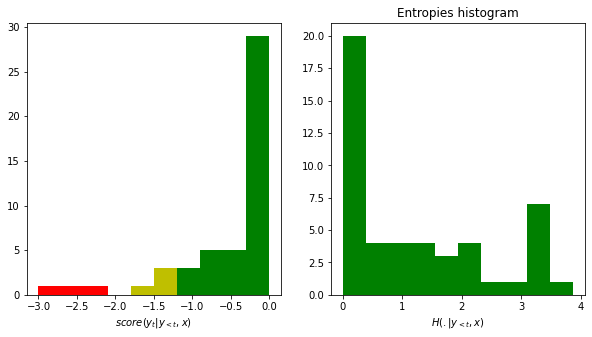

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

 Query: Write a biography of Ekaterina Fadeeva.
Answer:  Ekaterina Fadeeva (Russian: Екатерина Фадеева; born September 16, 1986) is a Russian professional ice dancer. She is the former Russian national champion and former Russian junior national champion. She is a former member of the Russian national team. She is a former member of the Russian junior national team. She is a former member of the Russian national team. She is a former member of the Russian junior national team. She is a former member of the

----------  -------  ---------  ------  --------  -------  -----  -----  ---------  ------  -------  -------  --------  ---------  ------  -----  --------  -------  ---------  ------  -------  ----------  -----  -------  -------  ------  -------  -------  --------  -------------  ------  -------  ---------  ------  ------  ------  -----  -------  --------  ---------  ---------  ------  -------  --------  -------  ---------  ---------  ------  ------  -----  -----  -------  -------  

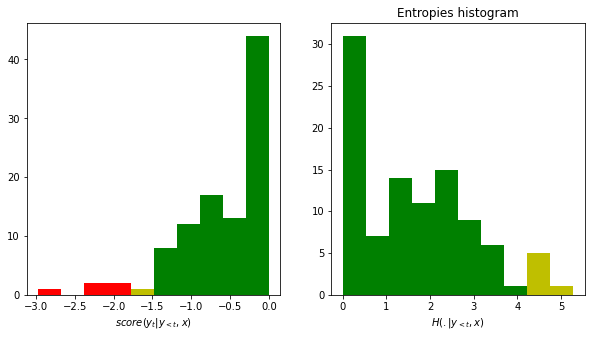

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

 Query: Write a biography of Jeniffer Walsh.
Answer:  Jennifer Walsh (born September 16, 1975) is an American actress, best known for her role as the title character in the Nickelodeon television series, Clarissa Explains It All.</s>

----------  ---------  ------  ------  -------  ----------  -----  -------  -------  ------  -------  ------  ---------  --------  -----  -----  --------  -------  ------  ------  ------  -----  ------  ----------  ------  ------  -------  ---------  --------  -----------  -------  -----  -----  -------  -----  ---------  ------  ---------  ------  ------
             Jennifer   Walsh   (      born      September  16     ,        1975     )        is       an      American   actress  ,       best   known     for      her     role    as      the    title   character   in      the     Nickel  ode        on         television   series  ,       Clar  issa      Expl  ains        It      All       .       </s>
max(score)  -0.574     -0.389  -0.508  -0.0996  -2.

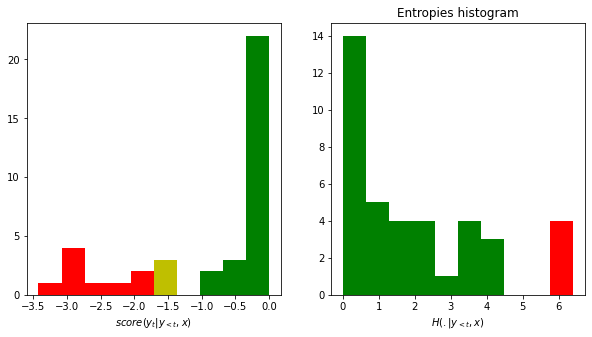

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

 Query: Write a biography of Jeniffer Walsh.
Answer:  Jennifer Walsh (born September 16, 1974) is an American actress, best known for her role as Detective Maggie McPherson on the CBS police procedural series Blue Bloods.</s>

----------  ---------  ------  ------  -----  ----------  -----  -------  -------  ------  -------  ------  ---------  --------  -----  -----  --------  -------  ------  ------  ------  ----------  -------  -----  ------  ------  ------  ------  -----  -------  -----------  -------  -----  -------  ---------  ------  ------
             Jennifer   Walsh   (      born    September  16     ,        1974     )        is       an      American   actress  ,       best   known     for      her     role    as      Detective   Maggie   Mc    Ph      erson    on      the     CBS    police   procedural   series   Blue   Blood   s          .       </s>
max(score)  -0.621     -0.383  -0.508  -0.1   -2.77       -2.84  -0.0157    -2.59  -0.299  -0.0332  -0.268  -0.084     -1.7

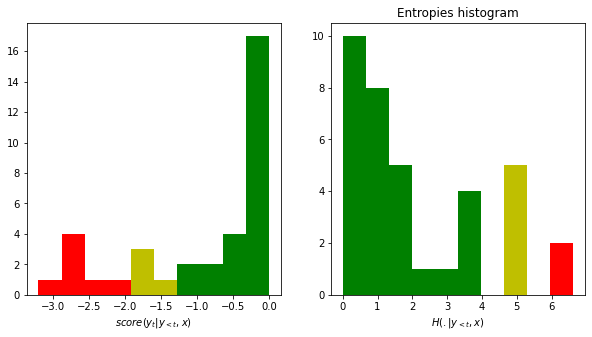

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

 Query: Write a biography of Du Xun.
Answer:  Du Xun (Chinese: 杜巽; pinyin: Du Xún; Wade–Giles: Tu Hsun; 16 March 1673 – 17 May 1751) was a Qing dynasty historian and writer. He was born in 1673 in the village of Shanyuan, in the present-day Shanyuan County, Henan, China. He was the son of Du Yue, a scholar of the Qing dynasty. Du Xun was educated at the Imperial Academy, where he studied under

----------  ------  --------  --------  ------  -------  -----  -------  ----  ------  ------  ---------  ------  ------  -----  -----  ------  ------  ---------  ---------  --------  ------  ------  -------  -----  -----  ------  -----  -----  -----  -----  -----  ------  -----  ------  -------  ------  ------  --------  ----------  -----  -------  ------  ------  ------  -----  ------  -----  -------  ------  -----  --------  ------  ----  ------  -------  ------  -----  -----  --------  ------  -----  ------  ---------  -------  ------  -----  ---------  -----  ------  ------  -----  ------  

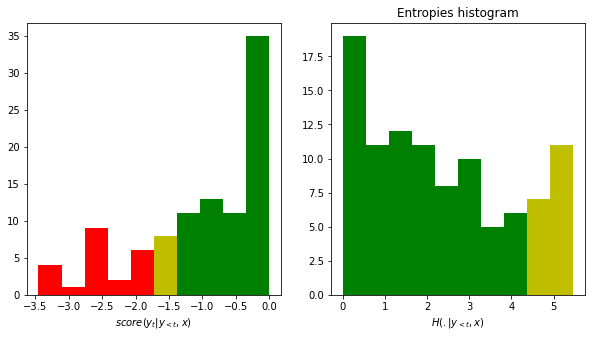

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

 Query: Write a biography of Du Xun.
Answer:  Du Xun (Chinese: 杜巽; pinyin: Du Xún; Wade–Giles: Tu Hsun; born September 16, 1943) is a Chinese historian and writer. He is currently a professor at the Institute of Modern History of the Chinese Academy of Social Sciences.</s>

----------  ------  -------  --------  ------  -------  -------  -------  -----  ------  ------  ---------  ------  ------  -----  -----  -----  ------  ---------  ---------  --------  ------  ------  -------  -----  -----  ----------  -----  -------  -------  ------  -------  -------  --------  ----------  ------  -------  ------  ------  ------  ----------  -----  ----------  ------  -----  ----------  -------  -------  --------  ------  ------  --------  --------  ---------  -------  ---------  -----  -----
             Du      X       un         (      Chinese  :         杜      巽     ;        piny   in:         Du      X      ún     ;       Wade  –       G          iles       :          Tu      H      sun      ;

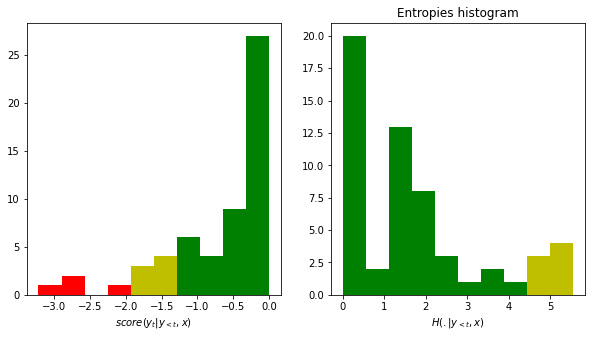

In [ ]:
for text_query in [
    # must be certain
    'Write a biography of Albert Enstein.',
    'Write a biography of Donald Trump.',
    # must be uncertain
    'Write a biography of Ekaterina Fadeeva.',
    'Write a biography of Jeniffer Walsh.',
    'Write a biography of Du Xun.',
]:
    for lambd, tau in [
        (0, 0), # usual greedy inference, without marginal term
        (0.0656, 3.599),  # optimal parameters for BARTS2S as in the paper
    ]:
        output_tokens, output_scores = experiment(model, tokenizer, text_query, lambd, tau)

In [ ]:
# btw model.generate() also generates one setence several times 

text_query = 'Write a biography of Ekaterina Fadeeva.'
inputs = tokenizer(text_query, return_tensors="pt")["input_ids"].cuda()
outputs = model.generate(inputs, max_new_tokens=200, output_scores=True)
tokenizer.decode(outputs[0])[len(text_query) + 1:]

'Ekaterina Fadeeva (Russian: Екатерина Фадеева; born September 16, 1990) is a Russian professional ice dancer. She is a former Russian national champion and former Russian junior national champion. She is a former Russian national team member. She is a former Russian junior national team member. She is a former Russian junior national team alternate. She is a former Russian national team alternate. She is a former Russian national team alternate. She is a former Russian national team alternate. She is a former Russian national team alternate. She is a former Russian national team alternate. She is a former Russian national team alternate. She is a former Russian national team alternate. She is a former Russian national team alternate. She is a former Russian national team alternate. She is a former Russian national team alternate. She is a former Russian national team alternate. She is a former Russian national team alternate. She is a former Russian national team alternate. She is a f

## Uncertanty estimation using Semantic Entropy

All methods are taken from [this paper](https://arxiv.org/pdf/2302.09664.pdf).

Used 4 different estimates of uncertalty (of the whole text, not each token):

* **Predictive Entropy**: Monte-Carlo entropy estimate, mean of $-\log p(y | x)$ among samples $y \sim p(y | x)$

* **Length-normalized Predictive Entropy**: same but using $\frac{p(y | x)}{|y|}$ instead of $p(y | x)$.

* **p(True)**: mean probability of $\text{"True"}$ when asking the model whether it's generated input is a correct answer, among all samples $y \sim p(y | x)$.

* **Lexical Similarity**: average Rouge-L similarity between all pairs of samples $y \sim p(y | x)$.

* **Semantic Entropy**: Monte-Carlo entropy estimate after grouping semanticaly similar outputs from samples $y$. Used same model (Deberta-large) for calculating semantic similarities.

In [8]:
# load deberta model

deberta = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-large-mnli", problem_type="multi_label_classification")
deberta_tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-large-mnli")

Downloading:   0%|          | 0.00/729 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

In [14]:
def sample(model, tokenizer, x, max_new_tokens=100, samples_num=5):  # 5-10 from paper
    tokens = model.generate(
        x, max_new_tokens=10, do_sample=True,
        num_return_sequences=samples_num, num_beams=samples_num,
        output_scores=True, return_dict_in_generate=True, 
        top_k=1000)  # (samples_num, max_new_tokens)
    logits = model(tokens).logits  # (samples_num, max_new_tokens, |dict|)
    logits = F.log_softmax(logits, dim=-1)

    # cut all after EOS in samples
    cut_tokens, cut_logits = [], []
    for sc, t in zip(logits, tokens):
        eos = (t == tokenizer.eos_token_id).to(dtype=torch.int)
        if eos.max() == 0:
            length = t.shape[0]
        else:
            length = eos.argmax().item()
        cut_tokens.append(t[x.shape[-1]:length])
        cut_logits.append(sc[x.shape[-1] - 1:length - 1])
    
    return cut_tokens, cut_logits

def log_likelihood(tokens, logits):
    return logits[np.arange(logits.shape[0]), tokens].sum().item()

def predictive_entropy(tokenizer, x, tokens, logits, verbose=False):
    # greater values means less certainty
    log_likelihoods = [
        log_likelihood(sample_tokens, sample_logits)
        for sample_tokens, sample_logits in zip(tokens, logits)]
    if verbose:
        print('\tlog likelihoods:', log_likelihoods)
    return -np.mean(log_likelihoods)

def length_normalized_predictive_entropy(tokenizer, x, tokens, logits, verbose=False):
    # greater values means less certainty
    log_likelihoods = [
        log_likelihood(sample_tokens, sample_logits) - np.log(max(len(sample_tokens), 1))
        for sample_tokens, sample_logits in zip(tokens, logits)]
    if verbose:
        print('\tlog likelihoods:', log_likelihoods)
    return -np.mean([ll / max(len(sample_tokens), 1)
           for sample_tokens, ll in zip(tokens, log_likelihoods)])

def p_true(tokenizer, x, tokens, logits, verbose=False):
    question = '''Question: "{}". Proposed Answer: "{}". Is the proposed answer True or False? True'''
    log_p_true = []
    for sample_tokens in tokens:
        q = question.format(tokenizer.decode(x[0]), tokenizer.decode(sample_tokens))
        tokenized_q = tokenizer(q, return_tensors="pt")["input_ids"].cuda()
        res = model(tokenized_q).logits
        ans_logits = F.log_softmax(res[0, -2])  # 'True' logit
        top = torch.topk(ans_logits, 100)
        true_logits = []
        for idx in top.indices:
            if tokenizer.decode([idx]).strip().lower() == 'true':
                true_logits.append(ans_logits[idx].item())
        log_p_true.append(np.logaddexp.reduce(true_logits))
        if verbose:
            print('\tlog p({}) = {}'.format(q, log_p_true[-1]))
    return -np.mean(log_p_true)  # minus to be less certain with greater scores

def lexical_similarity(tokenizer, x, tokens, logits, verbose=False):
    sims = []
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    for i in range(len(tokens)):
        for j in range(i + 1, len(tokens)):
            a1, a2 = tokenizer.decode(tokens[i]), tokenizer.decode(tokens[j])
            sims.append(scorer.score(a1, a2)['rougeL'].fmeasure)
            if verbose:
                print('\tLCS_len({}, {}) = {}'.format(a1, a2, sims[-1]))
    return -np.mean(sims)  # minus to be less certain with greater scores

def is_entailment(text1, text2):
    inp = deberta_tokenizer('[CLS] {} [SEP] {} [SEP]'.format(text1, text2), return_tensors="pt")
    return deberta(**inp).logits[0].argmax().item() == 1

def semantic_entropy(tokenizer, x, tokens, logits, verbose=False):
    # greater values means less certainty
    class_samples = [[0]]
    class_likelihoods = [[log_likelihood(tokens[0], logits[0])]]
    for i in range(1, len(tokens)):
        cur_text = tokenizer.decode(tokens[i])
        found_class = False
        ll = log_likelihood(tokens[i], logits[i])
        for class_id in range(len(class_samples)):
            class_text = tokenizer.decode(tokens[class_samples[class_id][0]])
            if not is_entailment(class_text, cur_text):
                continue
            if not is_entailment(cur_text, class_text):
                continue
            class_samples[class_id].append(i)
            class_likelihoods[class_id].append(ll)
            found_class = True
            break
        if not found_class:
            class_samples.append([i])
            class_likelihoods.append([ll])
    semantic_logits = [np.logaddexp.reduce(likelihoods) for likelihoods in class_likelihoods]
    if verbose:
        for c, cl in zip(class_samples, class_likelihoods):
            print('\tclass:')
            for i, ll in zip(c, cl):
                print('\t\tScore:', ll, 'Text:', tokenizer.decode(tokens[i]))
    return -np.mean(semantic_logits)

In [15]:
def experiment(text_query, max_new_tokens=40, samples_num=5, verbose=False):
    inputs = tokenizer(text_query, return_tensors="pt")["input_ids"].cuda()

    tokens, logits = sample(model, tokenizer, inputs,
                            max_new_tokens, samples_num)
    outp = {}

    print('=' * 100)
    print('Query: {}'.format(text_query))
    print('Sampled answers:')
    sampled_answers = [tokenizer.decode(t) for t in tokens]
    for t, l in zip(sampled_answers, logits):
        print('\tlog p(y|x) = {}, text: {}'.format(l.sum().item(), t))
    print()

    for name, func in [
        ('Predictive Entropy', predictive_entropy),
        ('Length-normalized Predictive Entropy', length_normalized_predictive_entropy),
        ('P(True)', p_true),
        ('Lexical Similarity', lexical_similarity),
        ('Semantic Entropy', semantic_entropy),
    ]:
        if verbose:
            print('Calculating {}'.format(name))
        uncertanty = func(tokenizer, inputs, tokens, logits, verbose)
        outp[name] = uncertanty
        print('{}: {}'.format(name, uncertanty))

    outp['samples'] = sampled_answers
    return outp

In [16]:
# Detailed logs of uncertanties calculations on this example
experiment('Suggest any random number:',
           max_new_tokens=2, samples_num=3, verbose=True)

Query: Suggest any random number:
Sampled answers:
	log p(y|x) = -47972352.0, text:  What was Roosevelt's known as T-Rex?
	log p(y|x) = -9764864.0, text:  eight eggs
	log p(y|x) = -4718592.0, text:  21

Calculating Predictive Entropy
	log likelihoods: [-39.0, -15.0, -5.21875]
Predictive Entropy: 19.739583333333332
Calculating Length-normalized Predictive Entropy
	log likelihoods: [-41.30258509299404, -15.693147180559945, -5.21875]
Length-normalized Predictive Entropy: 5.731860699859792
Calculating P(True)
	log p(Question: "Suggest any random number:". Proposed Answer: " What was Roosevelt's known as T-Rex?". Is the proposed answer True or False? True) = -4.249644711906647
	log p(Question: "Suggest any random number:". Proposed Answer: " eight eggs". Is the proposed answer True or False? True) = -2.7028559431134798


Mar 19 19:39:20.536 [INFO] Using default tokenizer.


	log p(Question: "Suggest any random number:". Proposed Answer: " 21". Is the proposed answer True or False? True) = -1.9138305375171303
P(True): 2.9554437308457526
Calculating Lexical Similarity
	LCS_len( What was Roosevelt's known as T-Rex?,  eight eggs) = 0.0
	LCS_len( What was Roosevelt's known as T-Rex?,  21) = 0.0
	LCS_len( eight eggs,  21) = 0.0
Lexical Similarity: -0.0
Calculating Semantic Entropy
	class:
		Score: -39.0 Text:  What was Roosevelt's known as T-Rex?
	class:
		Score: -15.0 Text:  eight eggs
	class:
		Score: -5.21875 Text:  21
Semantic Entropy: 19.739583333333332


{'Predictive Entropy': 19.739583333333332,
 'Length-normalized Predictive Entropy': 5.731860699859792,
 'P(True)': 2.9554437308457526,
 'Lexical Similarity': -0.0,
 'Semantic Entropy': 19.739583333333332,
 'samples': [" What was Roosevelt's known as T-Rex?", ' eight eggs', ' 21']}

In [17]:
outputs = {}

for query in [
    # must be certain
    'What is the capital of France?',
    'List at least 3 cities in Russia.',
    'What year was Albert Einstein born?',
    'Translate into English: "ты кому звонишь?".',
    # must be uncertain
    'What is the capital of Ucnucna?',
    'What year was Jeniffer Walsh born?',
    'Suggest any random number:',
    'Translate into English: "оттсл ылапи ыдс лм".',
]:
    outputs[query] = experiment(query)

Query: What is the capital of France?
Sampled answers:
	log p(y|x) = -5406720.0, text:  Paris
	log p(y|x) = -5406720.0, text:  Paris
	log p(y|x) = -5406720.0, text:  Paris
	log p(y|x) = -15794176.0, text:  Paris, France
	log p(y|x) = -15794176.0, text:  Paris, France

Predictive Entropy: 1.20626220703125
Length-normalized Predictive Entropy: 0.5527438455203313


Mar 19 19:43:28.238 [INFO] Using default tokenizer.


P(True): 0.036050648018926365
Lexical Similarity: -0.8
Semantic Entropy: 1.20626220703125
Query: List at least 3 cities in Russia.
Sampled answers:
	log p(y|x) = -53739520.0, text:  Moscow, St. Petersburg, Yekaterin
	log p(y|x) = -51118080.0, text:  Moscow, St. Petersberg and Volgogr
	log p(y|x) = 0.0, text: 
	log p(y|x) = -52953088.0, text:  Moscow, St Petersburg (Leningrad) and
	log p(y|x) = -47710208.0, text:  Moscow, St. Petersberg, Samara

Predictive Entropy: 6.94375
Length-normalized Predictive Entropy: 0.8981628739648922


Mar 19 19:49:16.699 [INFO] Using default tokenizer.


P(True): 0.718428144587606
Lexical Similarity: -0.3322222222222222
Semantic Entropy: 3.7802756807075264
Query: What year was Albert Einstein born?
Sampled answers:
	log p(y|x) = -5701632.0, text:  1879
	log p(y|x) = -5701632.0, text:  1879
	log p(y|x) = -5701632.0, text:  1879
	log p(y|x) = -5701632.0, text:  1879
	log p(y|x) = -5701632.0, text:  1879

Predictive Entropy: 0.0101318359375
Length-normalized Predictive Entropy: 0.0101318359375


Mar 19 19:52:45.183 [INFO] Using default tokenizer.


P(True): 0.054139990356481704
Lexical Similarity: -1.0
Semantic Entropy: 0.0101318359375
Query: Translate into English: "ты кому звонишь?".
Sampled answers:
	log p(y|x) = -30146560.0, text:  Who are you calling?
	log p(y|x) = -30146560.0, text:  Who are you calling?
	log p(y|x) = -43515904.0, text:  "Who are you calling?"
	log p(y|x) = -47448064.0, text:  "Whom are you calling?"
	log p(y|x) = -34603008.0, text:  "You're calling whom?"

Predictive Entropy: 2.7765625
Length-normalized Predictive Entropy: 0.7390474509601918


Mar 19 19:58:52.638 [INFO] Using default tokenizer.


P(True): 0.43968992453695355
Lexical Similarity: -0.725
Semantic Entropy: 2.7765625
Query: What is the capital of Ucnucna?
Sampled answers:
	log p(y|x) = -8847360.0, text:  Izzani
	log p(y|x) = -9568256.0, text:  Sana'a
	log p(y|x) = -4456448.0, text:  Montevideo
	log p(y|x) = -4456448.0, text:  Valencia
	log p(y|x) = -4456448.0, text:  Managua

Predictive Entropy: 8.59375
Length-normalized Predictive Entropy: 6.032379436111989


Mar 19 20:05:04.193 [INFO] Using default tokenizer.


P(True): 0.9306556353017521
Lexical Similarity: -0.0
Semantic Entropy: 8.59375
Query: What year was Jeniffer Walsh born?
Sampled answers:
	log p(y|x) = -4784128.0, text:  1971
	log p(y|x) = -4784128.0, text:  1976
	log p(y|x) = -4784128.0, text:  1981
	log p(y|x) = -4784128.0, text:  1981
	log p(y|x) = -4784128.0, text:  1961

Predictive Entropy: 3.575
Length-normalized Predictive Entropy: 3.575


Mar 19 20:08:31.034 [INFO] Using default tokenizer.


P(True): 0.27137399592211076
Lexical Similarity: -0.1
Semantic Entropy: 3.575
Query: Suggest any random number:
Sampled answers:
	log p(y|x) = -52166656.0, text:  678. How many syllables are there in the
	log p(y|x) = -13828096.0, text:  12.12
	log p(y|x) = -4718592.0, text:  237
	log p(y|x) = -4718592.0, text:  198
	log p(y|x) = -4718592.0, text:  18

Predictive Entropy: 11.1125
Length-normalized Predictive Entropy: 5.693459187771088


Mar 19 20:13:42.765 [INFO] Using default tokenizer.


P(True): 2.0841034126142204
Lexical Similarity: -0.0
Semantic Entropy: 11.1125
Query: Translate into English: "оттсл ылапи ыдс лм".
Sampled answers:
	log p(y|x) = -23068672.0, text:  A billion for one.
	log p(y|x) = -28835840.0, text:  Ayia Sophia is beautiful.
	log p(y|x) = -39845888.0, text:  Hold your tongue, you youngsters!
	log p(y|x) = -23592960.0, text:  The stone ticked.
	log p(y|x) = -44564480.0, text:  He had tied a letter to the bread.

Predictive Entropy: 25.05
Length-normalized Predictive Entropy: 4.15644637778513


Mar 19 20:19:59.312 [INFO] Using default tokenizer.


P(True): 1.816577292249466
Lexical Similarity: -0.03484848484848485
Semantic Entropy: 22.59152824111905


In [20]:
for uncertanty_estimate_name in [
    'Predictive Entropy', 'Length-normalized Predictive Entropy',
    'P(True)', 'Lexical Similarity', 'Semantic Entropy',
]:
    query_with_uncertanty = []
    for query, result in outputs.items():
        query_with_uncertanty.append((query, result[uncertanty_estimate_name]))
    query_with_uncertanty.sort(key=lambda x: x[1])
    print('Top certain queries according to {}:'.format(uncertanty_estimate_name))
    for query, unc in query_with_uncertanty:
        print('\tUncertanty: {}, Query: {}'.format(unc, query))
    print()

Top certain queries according to Predictive Entropy:
	Uncertanty: 0.0101318359375, Query: What year was Albert Einstein born?
	Uncertanty: 1.20626220703125, Query: What is the capital of France?
	Uncertanty: 2.7765625, Query: Translate into English: "ты кому звонишь?".
	Uncertanty: 3.575, Query: What year was Jeniffer Walsh born?
	Uncertanty: 6.94375, Query: List at least 3 cities in Russia.
	Uncertanty: 8.59375, Query: What is the capital of Ucnucna?
	Uncertanty: 11.1125, Query: Suggest any random number:
	Uncertanty: 25.05, Query: Translate into English: "оттсл ылапи ыдс лм".

Top certain queries according to Length-normalized Predictive Entropy:
	Uncertanty: 0.0101318359375, Query: What year was Albert Einstein born?
	Uncertanty: 0.5527438455203313, Query: What is the capital of France?
	Uncertanty: 0.7390474509601918, Query: Translate into English: "ты кому звонишь?".
	Uncertanty: 0.8981628739648922, Query: List at least 3 cities in Russia.
	Uncertanty: 3.575, Query: What year was 